Knowledge graphs 

Imports

In [1]:
from neo4j import GraphDatabase
import json
import networkx as nx
import matplotlib.pyplot as plt


Connect to neo4j

In [2]:
uri = "bolt://localhost:7687"  
username = "neo4j"            
password = "David1234"    
driver = GraphDatabase.driver(uri, auth=(username, password))

def test_connection():
    with driver.session() as session:
        result = session.run("RETURN 'Connection Successful' AS message")
        for record in result:
            print(record["message"])

test_connection()

Connection Successful


Get Data 

In [3]:
json_file_path = "data/simpledata.json"
with open(json_file_path, "r") as file:
    data = json.load(file)

actors = data.get("actors", [])
directors = data.get("directors", [])
studios = data.get("studios", [])
genres = data.get("genres", [])
movies = data.get("movies", [])

Used for clearing the data

In [4]:
def delete_all_data():
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
    print("All data deleted successfully!")

delete_all_data()

All data deleted successfully!


Creating the Knowledge graph 

In [5]:
def create_graph():
    with driver.session() as session:
        # Create Actor Nodes
        for actor in actors:
            session.run("""
            CREATE (:Actor {id: $id, name: $name, birth_year: $birth_year, gender: $gender})
            """, actor)

        # Create Director Nodes
        for director in directors:
            session.run("""
            CREATE (:Director {id: $id, name: $name, birth_year: $birth_year})
            """, director)

        # Create Studio Nodes
        for studio in studios:
            session.run("""
            CREATE (:Studio {id: $id, name: $name})
            """, studio)

        # Create Genre Nodes
        for genre in genres:
            session.run("""
            CREATE (:Genre {id: $id, name: $name})
            """, genre)

        # Create Movie Nodes and Relationships
        for movie in movies:
            # Create Movie Node
            session.run("""
            CREATE (:Movie {id: $id, title: $title, release_year: $release_year, rating: $rating})
            """, movie)

            # Create ACTED_IN Relationships
            for actor_id in movie["actor_ids"]:
                session.run("""
                MATCH (a:Actor {id: $actor_id}), (m:Movie {id: $movie_id})
                CREATE (a)-[:ACTED_IN]->(m)
                """, {"actor_id": actor_id, "movie_id": movie["id"]})

            # Create DIRECTED Relationship
            session.run("""
            MATCH (d:Director {id: $director_id}), (m:Movie {id: $movie_id})
            CREATE (d)-[:DIRECTED]->(m)
            """, {"director_id": movie["director_id"], "movie_id": movie["id"]})

            # Create PRODUCED_BY Relationship
            session.run("""
            MATCH (s:Studio {id: $studio_id}), (m:Movie {id: $movie_id})
            CREATE (m)-[:PRODUCED_BY]->(s)
            """, {"studio_id": movie["studio_id"], "movie_id": movie["id"]})

            # Create BELONGS_TO_GENRE Relationships
            for genre_id in movie["genre_ids"]:
                session.run("""
                MATCH (m:Movie {id: $movie_id}), (g:Genre {id: $genre_id})
                CREATE (m)-[:BELONGS_TO_GENRE]->(g)
                """, {"movie_id": movie["id"], "genre_id": genre_id})

        print("Graph created successfully!")

create_graph()


Graph created successfully!


Fetch data from the graph

In [6]:
def fetch_graph_data():
    query = """
    MATCH (n)-[r]->(m)
    RETURN n, r, m
    """
    with driver.session() as session:
        result = session.run(query)
        edges = []
        nodes = set()
        for record in result:
            n = record["n"]
            m = record["m"]
            r = record["r"]
            nodes.add((n["id"], n["name"]))
            nodes.add((m["id"], m["name"]))
            edges.append((n["id"], m["id"], r.type))
    return nodes, edges

fetch_graph_data()

({('A1', 'Keanu Reeves'),
  ('A2', 'Laurence Fishburne'),
  ('A3', 'Anne Hathaway'),
  ('A4', 'Leonardo DiCaprio'),
  ('A5', 'Meryl Streep'),
  ('D1', 'Christopher Nolan'),
  ('D2', 'James Cameron'),
  ('D3', 'Lana Wachowski'),
  ('G1', 'Action'),
  ('G2', 'Drama'),
  ('G3', 'Sci-Fi'),
  ('M1', None),
  ('M2', None),
  ('M3', None),
  ('M4', None),
  ('S1', 'Warner Bros'),
  ('S2', '20th Century Fox'),
  ('S3', 'Paramount Pictures')},
 [('A1', 'M1', 'ACTED_IN'),
  ('A2', 'M1', 'ACTED_IN'),
  ('A3', 'M2', 'ACTED_IN'),
  ('A3', 'M4', 'ACTED_IN'),
  ('A4', 'M2', 'ACTED_IN'),
  ('A4', 'M3', 'ACTED_IN'),
  ('A5', 'M4', 'ACTED_IN'),
  ('D1', 'M2', 'DIRECTED'),
  ('D2', 'M3', 'DIRECTED'),
  ('D2', 'M4', 'DIRECTED'),
  ('D3', 'M1', 'DIRECTED'),
  ('M1', 'G1', 'BELONGS_TO_GENRE'),
  ('M1', 'G3', 'BELONGS_TO_GENRE'),
  ('M1', 'S1', 'PRODUCED_BY'),
  ('M2', 'G1', 'BELONGS_TO_GENRE'),
  ('M2', 'G2', 'BELONGS_TO_GENRE'),
  ('M2', 'S1', 'PRODUCED_BY'),
  ('M3', 'G2', 'BELONGS_TO_GENRE'),
  ('M3', 'S

Simple visualization of the data. For the best visalization run this comand in neo4j 
< MATCH (n) OPTIONAL MATCH (n)-[r]->(m) RETURN n, r, m > .

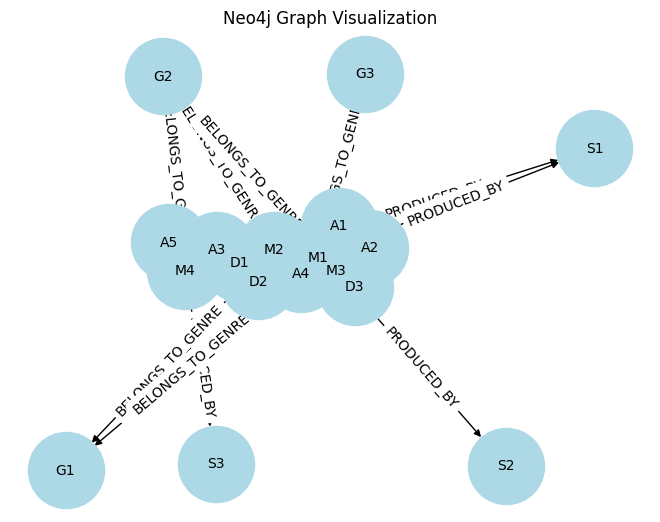

In [7]:
def visualize_graph(nodes, edges):
    graph = nx.DiGraph()

    for node_id, node_name in nodes:
        graph.add_node(node_id, label=node_name)

    for source, target, rel_type in edges:
        graph.add_edge(source, target, label=rel_type)

    pos = nx.spring_layout(graph)  
    nx.draw(graph, pos, with_labels=True, node_color="lightblue", node_size=3000, font_size=10)

    edge_labels = nx.get_edge_attributes(graph, 'label')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    plt.title("Neo4j Graph Visualization")
    plt.show()

nodes, edges = fetch_graph_data()
visualize_graph(nodes, edges)